[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimal Portfolio Allocation:
AAPL: 18.30%
MSFT: 29.31%
DELL: 0.00%
ET: 52.39%

Optimal Portfolio Return: 22.73%
Optimal Portfolio Volatility (Risk): 13.01%


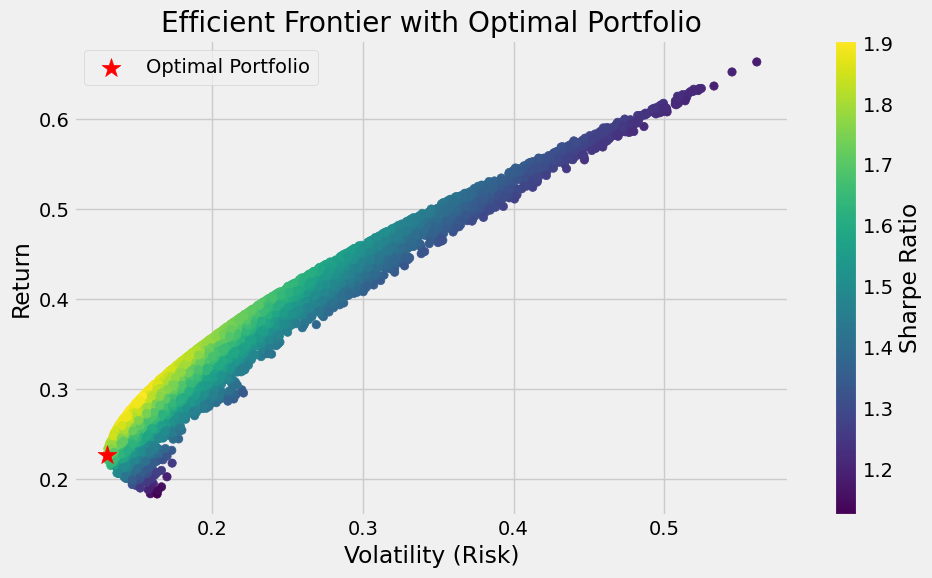

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
from scipy.optimize import minimize
plt.style.use('fivethirtyeight')  # Setting matplotlib style

# Function to fetch historical close prices for a given ticker
def get_close_data(ticker, period="1y"):
    """
    Fetches the closing prices for a given stock ticker and returns it as a pandas DataFrame
    with the 'Close' column renamed to the ticker symbol.

    Parameters:
    ticker (str): The stock ticker symbol.
    period (str): The period over which to download the data (default is '1y').

    Returns:
    pd.DataFrame: DataFrame with the renamed 'Close' column.
    """
    data = yf.download(ticker, period=period)  # Download data for the given period
    close_data = data['Close']  # Extract the 'Close' column
    close_df = pd.DataFrame(close_data).rename(columns={"Close": ticker})  # Rename 'Close' to ticker symbol
    return close_df

# Fetch data for multiple tickers
tickers = ["AAPL", "MSFT", "DELL", "ET"]
portfolio_data = [get_close_data(ticker) for ticker in tickers]

# Concatenate the ticker DataFrames
df_portfolio = pd.concat(portfolio_data, axis=1)

# Calculate daily returns
daily_returns = df_portfolio.pct_change().dropna()

# Mean and Covariance of Returns
mean_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of assets
num_assets = len(tickers)

# Portfolio Optimization
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate the portfolio's return and volatility based on given weights.

    Parameters:
    weights (array-like): Array of portfolio weights.
    mean_returns (pd.Series): Mean returns of assets.
    cov_matrix (pd.DataFrame): Covariance matrix of asset returns.

    Returns:
    float: Portfolio return.
    float: Portfolio volatility.
    """
    returns = np.sum(mean_returns * weights) * 252  # Annualized Return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized Volatility
    return returns, volatility

# Minimize Portfolio Volatility
def minimize_volatility(weights, mean_returns, cov_matrix):
    """
    Objective function to minimize portfolio volatility.
    """
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints: Weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds for weights: 0 <= weight <= 1 (no short selling allowed)
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess for weights: Equal allocation
initial_weights = num_assets * [1. / num_assets]

# Minimize volatility to find the optimal weights
optimized_results = minimize(minimize_volatility, initial_weights,
                             args=(mean_daily_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights = optimized_results.x

# Display the optimal portfolio allocation
print("Optimal Portfolio Allocation:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

# Portfolio Performance with Optimal Weights
opt_returns, opt_volatility = portfolio_performance(optimal_weights, mean_daily_returns, cov_matrix)
print(f"\nOptimal Portfolio Return: {opt_returns:.2%}")
print(f"Optimal Portfolio Volatility (Risk): {opt_volatility:.2%}")

# Plotting Efficient Frontier
def portfolio_statistics(weights, mean_returns, cov_matrix):
    """
    Calculate the portfolio return, volatility, and Sharpe ratio for given weights.
    """
    returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = returns / volatility
    return returns, volatility, sharpe_ratio

# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    returns, volatility, sharpe = portfolio_statistics(weights, mean_daily_returns, cov_matrix)
    results[0,i] = returns
    results[1,i] = volatility
    results[2,i] = sharpe

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_volatility, opt_returns, marker='*', color='r', s=200, label='Optimal Portfolio')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
